# Random Forest Classifier

In [ ]:
# Import dependencies for ML
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [46]:
# Import Dependencies for Database
from config import password
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import psycopg2
import pandas as pd

In [32]:
db_string = f"postgresql+psycopg2://postgres:" + password + "@127.0.0.1:5434/WineEnthusiast"

In [33]:
engine = create_engine(db_string)

In [34]:
inspector = inspect(engine)

In [37]:
inspector.get_table_names()

['winemag', 'wineregions', 'wine']

In [44]:
connection = engine.connect

In [17]:
session = Session(engine)

In [105]:
engine.execute("SELECT * from wine")

In [106]:
col_names_list = []

#i = 0
for i in range(len(inspector.get_columns('wine'))):
    col_names_list.append(inspector.get_columns('wine')[i]['name'])
    
for i in range(len(inspector.get_columns('wineregions'))):
    col_names_list.append(inspector.get_columns('wineregions')[i]['name'])
    
print(col_names_list)

['index', 'description', 'points', 'price', 'province', 'region_1', 'region_2', 'title', 'variety', 'winery', 'region', 'latitude', 'longitude']


In [107]:
US_wine_data_df = pd.DataFrame(columns = col_names_list)

In [108]:
# Inner join for wines and regions
import sys
join_db = engine.execute("SELECT * from wine inner join wineregions on wine.region_1 = wineregions.region")
for record in join_db:
    record_series = pd.Series(list(record), index = US_wine_data_df.columns)
    
    US_wine_data_df = US_wine_data_df.append(record_series, ignore_index=True)
    #print(list(record))

In [110]:
US_wine_data_df.head()

,index,description,points,price,province,region_1,region_2,title,variety,winery,region,latitude,longitude
0,2,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Willamette Valley,44.942600,-122.933800
1,4,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley,44.942600,-122.933800
2,10,"Soft, supple plum envelopes an oaky structure ...",87,19.0,California,Napa Valley,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,Napa Valley,38.427400,-122.394300
3,33,"Rustic and dry, this has flavors of berries, c...",86,50.0,California,Dry Creek Valley,Sonoma,Envolve 2010 Puma Springs Vineyard Red (Dry Cr...,Red Blend,Envolve,Dry Creek Valley,38.760182,-122.615263
4,34,"This shows a tart, green gooseberry flavor tha...",86,20.0,California,Sonoma Valley,Sonoma,Envolve 2011 Sauvignon Blanc (Sonoma Valley),Sauvignon Blanc,Envolve,Sonoma Valley,38.208250,-122.417755


In [111]:
US_wine_data_df.columns

Index(['index', 'description', 'points', 'price', 'province', 'region_1',
       'region_2', 'title', 'variety', 'winery', 'region', 'latitude',
       'longitude'],
      dtype='object')

In [112]:
US_wine_data_df.drop(columns = 'index', inplace=True)

In [113]:
US_wine_data_df.head()

,description,points,price,province,region_1,region_2,title,variety,winery,region,latitude,longitude
0,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Willamette Valley,44.942600,-122.933800
1,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley,44.942600,-122.933800
2,"Soft, supple plum envelopes an oaky structure ...",87,19.0,California,Napa Valley,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,Napa Valley,38.427400,-122.394300
3,"Rustic and dry, this has flavors of berries, c...",86,50.0,California,Dry Creek Valley,Sonoma,Envolve 2010 Puma Springs Vineyard Red (Dry Cr...,Red Blend,Envolve,Dry Creek Valley,38.760182,-122.615263
4,"This shows a tart, green gooseberry flavor tha...",86,20.0,California,Sonoma Valley,Sonoma,Envolve 2011 Sauvignon Blanc (Sonoma Valley),Sauvignon Blanc,Envolve,Sonoma Valley,38.208250,-122.417755


In [114]:
# joined data set with lat long and wine
US_wine_data_df.to_sql(name='uswine', con=engine)

In [ ]:
# Cut this out
# Import data
US_wine_data_df = pd.read_csv("Data/US_wine_data.csv")
print(US_wine_data_df.shape)
US_wine_data_df.head()

In [115]:
# Make a copy of the dataframe
US_wine_data_df_copy = US_wine_data_df
US_wine_data_df_copy.shape

(8642, 12)

## Pre process for machine learning

In [116]:
# Group wine price into bins.
price_counts = US_wine_data_df.price.value_counts()
price_counts

20.0     412
35.0     405
50.0     396
25.0     385
30.0     383
        ... 
179.0      1
235.0      1
102.0      1
450.0      1
117.0      1
Name: price, Length: 130, dtype: int64

<AxesSubplot:ylabel='Density'>

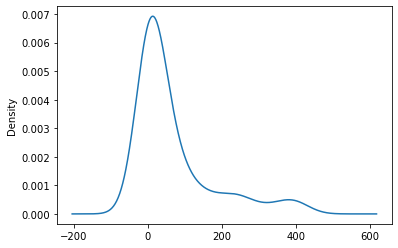

In [117]:
price_counts.plot.density()

In [118]:
# Create price bins
price_bins = [0, 15, 30, 60, 100, 500, 5000]
US_wine_data_df.groupby(pd.cut(US_wine_data_df["price"], price_bins)).count()

price_bins_names = ["<$15","$15-30","$30-60","$60-100", "100-500","too much"]

# Make a new column in dataframe for price bins.
US_wine_data_df["price_bins"] = pd.cut(US_wine_data_df["price"], price_bins, labels=price_bins_names)

# Check dataframe
US_wine_data_df.tail()

,description,points,price,province,region_1,region_2,title,variety,winery,region,latitude,longitude,price_bins
8637,"Aged entirely in stainless steel, this combine...",91,30.0,California,Napa Valley,Napa,Paraduxx 2015 Proprietary White (Napa Valley),White Blend,Paraduxx,Napa Valley,38.427400,-122.394300,$15-30
8638,Pencil shaving and graphite notes lend a class...,91,35.0,California,Napa Valley,Napa,Conn Creek 2013 Cabernet Sauvignon (Napa Valley),Cabernet Sauvignon,Conn Creek,Napa Valley,38.427400,-122.394300,$30-60
8639,Fritz has made tremendous progress with Cab ov...,91,35.0,California,Dry Creek Valley,Sonoma,Fritz 2005 Cabernet Sauvignon (Dry Creek Valley),Cabernet Sauvignon,Fritz,Dry Creek Valley,38.760182,-122.615263,$30-60
8640,There's no bones about the use of oak in this ...,90,35.0,California,Napa Valley,Napa,Flora Springs 2013 Barrel Fermented Chardonnay...,Chardonnay,Flora Springs,Napa Valley,38.427400,-122.394300,$30-60
8641,This opens with herbaceous dollops of thyme an...,90,35.0,California,Napa Valley,Napa,Hendry 2012 Blocks 7 & 22 Zinfandel (Napa Valley),Zinfandel,Hendry,Napa Valley,38.427400,-122.394300,$30-60


In [119]:
# Create a DataFrame to hold columns ("description", "price", "province", "region_2", "title", "winery")
# that won't be used in machine learning in case we want them later.
US_wine_data_title_df = US_wine_data_df.drop(columns=["points", "region_1", "variety","price_bins"], axis=1)
print(US_wine_data_title_df.shape)
US_wine_data_title_df.head()

(8642, 9)


,description,price,province,region_2,title,winery,region,latitude,longitude
0,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm,Willamette Valley,44.942600,-122.933800
1,"Much like the regular bottling from 2012, this...",65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks,Willamette Valley,44.942600,-122.933800
2,"Soft, supple plum envelopes an oaky structure ...",19.0,California,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Kirkland Signature,Napa Valley,38.427400,-122.394300
3,"Rustic and dry, this has flavors of berries, c...",50.0,California,Sonoma,Envolve 2010 Puma Springs Vineyard Red (Dry Cr...,Envolve,Dry Creek Valley,38.760182,-122.615263
4,"This shows a tart, green gooseberry flavor tha...",20.0,California,Sonoma,Envolve 2011 Sauvignon Blanc (Sonoma Valley),Envolve,Sonoma Valley,38.208250,-122.417755


In [121]:
# Export data with price bins
# Save cleaned columns ("description", "price", "province", "region_2", "title", "winery","latitude", "longitude")
US_wine_data_title_df.to_sql(name='winedata', con=engine)

In [ ]:
# Save cleaned columns ("description", "price", "province", "region_2", "title", "winery")
# in case we want to load into database later.
US_wine_data_title_df.to_csv("Data/US_wine_data_title.csv", index=False)

In [123]:
# Create DataFrame for machine learning model. Drop: "description" - of flavors, i.e. tart and snappy, 
# oaky, etc., price, province, region_2, "title" - name on the bottle, winery.
# Dropped lat and long

US_wine_data_df_ml = US_wine_data_df.drop(columns=["description", "price", "province", "region_2", "title", "winery", "latitude", "longitude"], axis=1)
print(US_wine_data_df_ml.shape)
US_wine_data_df_ml.head()

(8642, 5)


,points,region_1,variety,region,price_bins
0,87,Willamette Valley,Pinot Gris,Willamette Valley,<$15
1,87,Willamette Valley,Pinot Noir,Willamette Valley,$60-100
2,87,Napa Valley,Cabernet Sauvignon,Napa Valley,$15-30
3,86,Dry Creek Valley,Red Blend,Dry Creek Valley,$30-60
4,86,Sonoma Valley,Sauvignon Blanc,Sonoma Valley,$15-30


In [ ]:
# Delete This 
#Save preprocessed dataframe (columns for machine learning: "points","region_1",""variety","price_bins")
US_wine_data_df_ml.to_csv("Data/US_wine_data_ml.csv", index=False)

In [124]:
# Export data for ML: (columns for machine learning: "points","region_1",""variety","price_bins")
US_wine_data_df_ml.to_sql(name='winedata_ml', con=engine)

### Checkpoint

In [ ]:
# Import data
US_wine_data_df_ml = pd.read_csv("Data/US_wine_data_ml.csv")
print(US_wine_data_df_ml.shape)
US_wine_data_df_ml.head()

In [ ]:
# Look at unique values to see if categorical data requires binning
US_wine_data_df_ml.nunique()

In [ ]:
# Determine value_counts for binning
variety_counts = US_wine_data_df_ml.variety.value_counts()
variety_counts

In [ ]:
# Visualize the value counts of variety
variety_counts.plot.density()

In [ ]:
# Determine which values to replace.  Per the plot, we tried <500 but after looking
# results we decided that we wanted to be more inclusive since some mainstream wines
# would be binned in "other".  Therefore we lowered the threshold for other to 300.
replace_variety = list(variety_counts[variety_counts <= 300].index)

# Replace in dataframe
for variety in replace_variety:
    US_wine_data_df_ml.variety = US_wine_data_df_ml.variety.replace(variety,"Other")
    
# Check to make sure binning was successful
US_wine_data_df_ml.variety.value_counts()

In [ ]:
# Determine value_counts for binning
region_1_counts = US_wine_data_df_ml.region_1.value_counts()
region_1_counts

In [ ]:
# Visualize the value counts of region_1
region_1_counts.plot.density()

In [ ]:
# From the plot the curve breaks around 500.
replace_region_1 = list(region_1_counts[region_1_counts <= 300].index)

# Replace in dataframe
for region_1 in replace_region_1:
    US_wine_data_df_ml.region_1 = US_wine_data_df_ml.region_1.replace(region_1,"Other")
    
# Check to make sure binning was successful
US_wine_data_df_ml.region_1.value_counts()

### Encode categorical data

In [ ]:
# Create variable to hold categorical columns for OneHotEncoder
wine_cat = ["variety", "region_1"]

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(US_wine_data_df_ml[wine_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(wine_cat)
encode_df.shape
encode_df.head()

In [ ]:
# Merge one-hot encoded features and drop the originals
US_wine_data_df_ml = US_wine_data_df_ml.merge(encode_df,left_index=True, right_index=True)
US_wine_data_df_ml = US_wine_data_df_ml.drop(wine_cat,axis=1)
print(US_wine_data_df_ml.shape)
US_wine_data_df_ml.head()

In [ ]:
# Save preprocessed dataframe to csv for future reference.
US_wine_data_df_ml.to_csv("Data/US_wine_data_enc.csv", index=False)

In [ ]:
# Import data
US_wine_data_df_ml = pd.read_csv("Data/US_wine_data_enc.csv")

### Split preprocessed data 

In [ ]:
# from sklearn.model_selection import train_test_split
# Split preprocessed data into our features and target arrays
#  Target
y = US_wine_data_df_ml["price_bins"].values
# Features
X = US_wine_data_df_ml.drop(["price_bins"],axis=1).values

In [ ]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
print(X_train_scaled [0:5])

## Machine Learning

### Try RandomForestClassifier

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Create a random forest classifier. 
rf_model = RandomForestClassifier(n_estimators=500, random_state=1) 

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data.
y_pred = rf_model.predict(X_test_scaled)

In [ ]:
# Display the confustion matrix
# from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [ ]:
# Calculate the accuracy score
# from sklearn.metrics import accuracy_score, classification_report
acc_score = accuracy_score(y_test, y_pred)

In [ ]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))